**LIVEFACE DETECTION ON MOBILE DEVICES**

**AIM**

The goal of this task is to identify liveface by different types of mobile cameras

Data, that we have to combine :

    1. KASPI LIVE   
    2. KASPI FAKE DEVICE VISIBLE
    3. KASPI FAKE DEVICE INVISIBLE
    4. KASPI FAKE PHOTO
    5. YDL LIVE
    6. YDL FAKE 
    7. YDL LIVE VAL TEST
    8. YDL FAKE VAL TEST 

# Import Modules

**Standard Modules**

In [32]:
import os
import gc
import pickle as pkl

from os import listdir
from os.path import join, isfile
from collections import Counter

**External Modules**

In [2]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

In [3]:
from sklearn.manifold import MDS                        
from sklearn.manifold import TSNE
from sklearn import random_projection                    
from sklearn.decomposition import PCA    

In [26]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Internal Modules**

# Helpers

In [4]:
def get_images_generator(path, all_images):
    
    label = 'LIVE' if path.find('LIVE') > 0 else 'FAKE'
    
#     print(label)
    
    files_names = [file for file in listdir(path) if isfile(join(path, file))]
    
#     images = [Image.open(fp = join(path, file)) for file in files_names]
    
    images_generator = (cv2.imread(filename = join(path,file)) for file in files_names)
    
    all_images[path[path.find('/') + 1:].replace('/', '_')] = {
        'count_of_images'  : len(files_names),
        'images_generator' : images_generator,
        'label' : label
    }
    
    return None

# Load Data

**Constants**

In [5]:
all_images = {}

In [6]:
image_case = 'Cropped'

In [7]:
ABS_PATH = 'Data'

KASPI_LIVE_PATH = os.path.join(ABS_PATH, 'KASPI/{}/LIVE'.format(image_case))

KASPI_FAKE_DEVICE_VISIBLE = os.path.join(ABS_PATH, 'KASPI/{}/FAKE/DEVICE_VISIBLE'.format(image_case))
KASPI_FAKE_DEVICE_INVISIBLE = os.path.join(ABS_PATH, 'KASPI/{}/FAKE/DEVICE'.format(image_case))
KASPI_FAKE_PHOTO = os.path.join(ABS_PATH, 'KASPI/{}/FAKE/PHOTO'.format(image_case))

YDL_LIVE = os.path.join(ABS_PATH, 'YDL/LIVE/{}'.format('Original'))
YDL_LIVE_VAL_TEST = os.path.join(ABS_PATH, 'YDL/LIVE/Test')

YDL_FAKE = os.path.join(ABS_PATH, 'YDL/FAKE/{}'.format('Original'))
YDL_FAKE_VAL_TEST = os.path.join(ABS_PATH, 'YDL/FAKE/Test')

In [8]:
KASPI_LIVE_PATH[len(ABS_PATH) + 1:]

'KASPI/Cropped/LIVE'

In [9]:
ALL_PATHES = (
    
    KASPI_LIVE_PATH,
#     KASPI_FAKE_DEVICE_VISIBLE,
    KASPI_FAKE_DEVICE_INVISIBLE,
    KASPI_FAKE_PHOTO,
    YDL_LIVE,
    YDL_LIVE_VAL_TEST,
    YDL_FAKE,
    YDL_FAKE_VAL_TEST

)

In [88]:
for path in ALL_PATHES:
    print(path.split('/'))

['Data', 'KASPI', 'Cropped', 'LIVE']
['Data', 'KASPI', 'Cropped', 'FAKE', 'DEVICE']
['Data', 'KASPI', 'Cropped', 'FAKE', 'PHOTO']
['Data', 'YDL', 'LIVE', 'Original']
['Data', 'YDL', 'LIVE', 'Test']
['Data', 'YDL', 'FAKE', 'Original']
['Data', 'YDL', 'FAKE', 'Test']


In [116]:
for path in ALL_PATHES:
    get_images_generator(path, all_images)

In [92]:
all_images.keys()

dict_keys(['KASPI_Original_LIVE_1', 'KASPI_Original_FAKE_DEVICE_VISIBLE', 'KASPI_Original_FAKE_DEVICE', 'KASPI_Original_FAKE_PHOTO', 'YDL_LIVE_Original', 'YDL_LIVE_Test', 'YDL_FAKE_Original', 'YDL_FAKE_Test', 'KASPI_Cropped_LIVE', 'KASPI_Cropped_FAKE_DEVICE', 'KASPI_Cropped_FAKE_PHOTO'])

In [117]:
live_count = 0
fake_count = 0

for dataset in all_images:
    
    print('{} : {} images : {} label'.format(dataset, 
                                             all_images[dataset]['count_of_images'],
                                             all_images[dataset]['label']))
    
    print()
    
    if all_images[dataset]['label'] == 'LIVE':
        live_count += all_images[dataset]['count_of_images']
    
    else:
        fake_count += all_images[dataset]['count_of_images']

print('TOTAL LIVE : ', live_count)
print('TOTAL FAKE : ', fake_count)

KASPI_Cropped_LIVE : 1148 images : LIVE label

KASPI_Cropped_FAKE_DEVICE : 238 images : FAKE label

KASPI_Cropped_FAKE_PHOTO : 240 images : FAKE label

YDL_LIVE_Original : 383 images : LIVE label

YDL_LIVE_Test : 103 images : LIVE label

YDL_FAKE_Original : 375 images : FAKE label

YDL_FAKE_Test : 99 images : FAKE label

TOTAL LIVE :  1634
TOTAL FAKE :  952


In [22]:
test_image = next(all_images['KASPI_Original_LIVE_1']['images_generator'])

In [10]:
def get_images(path):
    
    files_names = [file for file in listdir(path) if isfile(join(path, file)) and not file.endswith('.txt')]
    
    images = np.array([cv2.imread(filename = join(path,file)) for file in files_names])
    
    images.shape = (len(files_names), 256, 256, 3)
    
    print(images.shape)
    
    return images

In [11]:
kaspi_live_cropped_images = get_images(path = KASPI_LIVE_PATH)

(1147, 256, 256, 3)


In [12]:
kaspi_fake_device_cropped_images = get_images(path = KASPI_FAKE_DEVICE_INVISIBLE)

(237, 256, 256, 3)


In [13]:
kaspi_fake_photo_cropped_images = get_images(path = KASPI_FAKE_PHOTO)

(239, 256, 256, 3)


In [14]:
all_live = kaspi_live_cropped_images
all_fake = np.concatenate((kaspi_fake_device_cropped_images, kaspi_fake_photo_cropped_images))
# kaspi_fake_device_cropped_images  kaspi_fake_photo_cropped_images

In [15]:
all_live.shape

(1147, 256, 256, 3)

In [16]:
all_fake.shape

(476, 256, 256, 3)

In [17]:
live_labels = [1] * len(all_live)
fake_labels = [0] * len(all_fake)

In [18]:
X = np.concatenate((all_live,all_fake))
Y = live_labels + fake_labels

In [19]:
X.shape

(1623, 256, 256, 3)

In [21]:
len(X)

1623

In [23]:
X.shape = (len(X), 256 * 256 * 3)

In [24]:
X.shape

(1623, 196608)

# Random Projection

In [38]:
colorful = ['violet','yellow']

live = plt.Line2D(range(10), range(10), marker='o', color=colorful[0])
fake = plt.Line2D(range(10), range(10), marker='x',color=colorful[1])

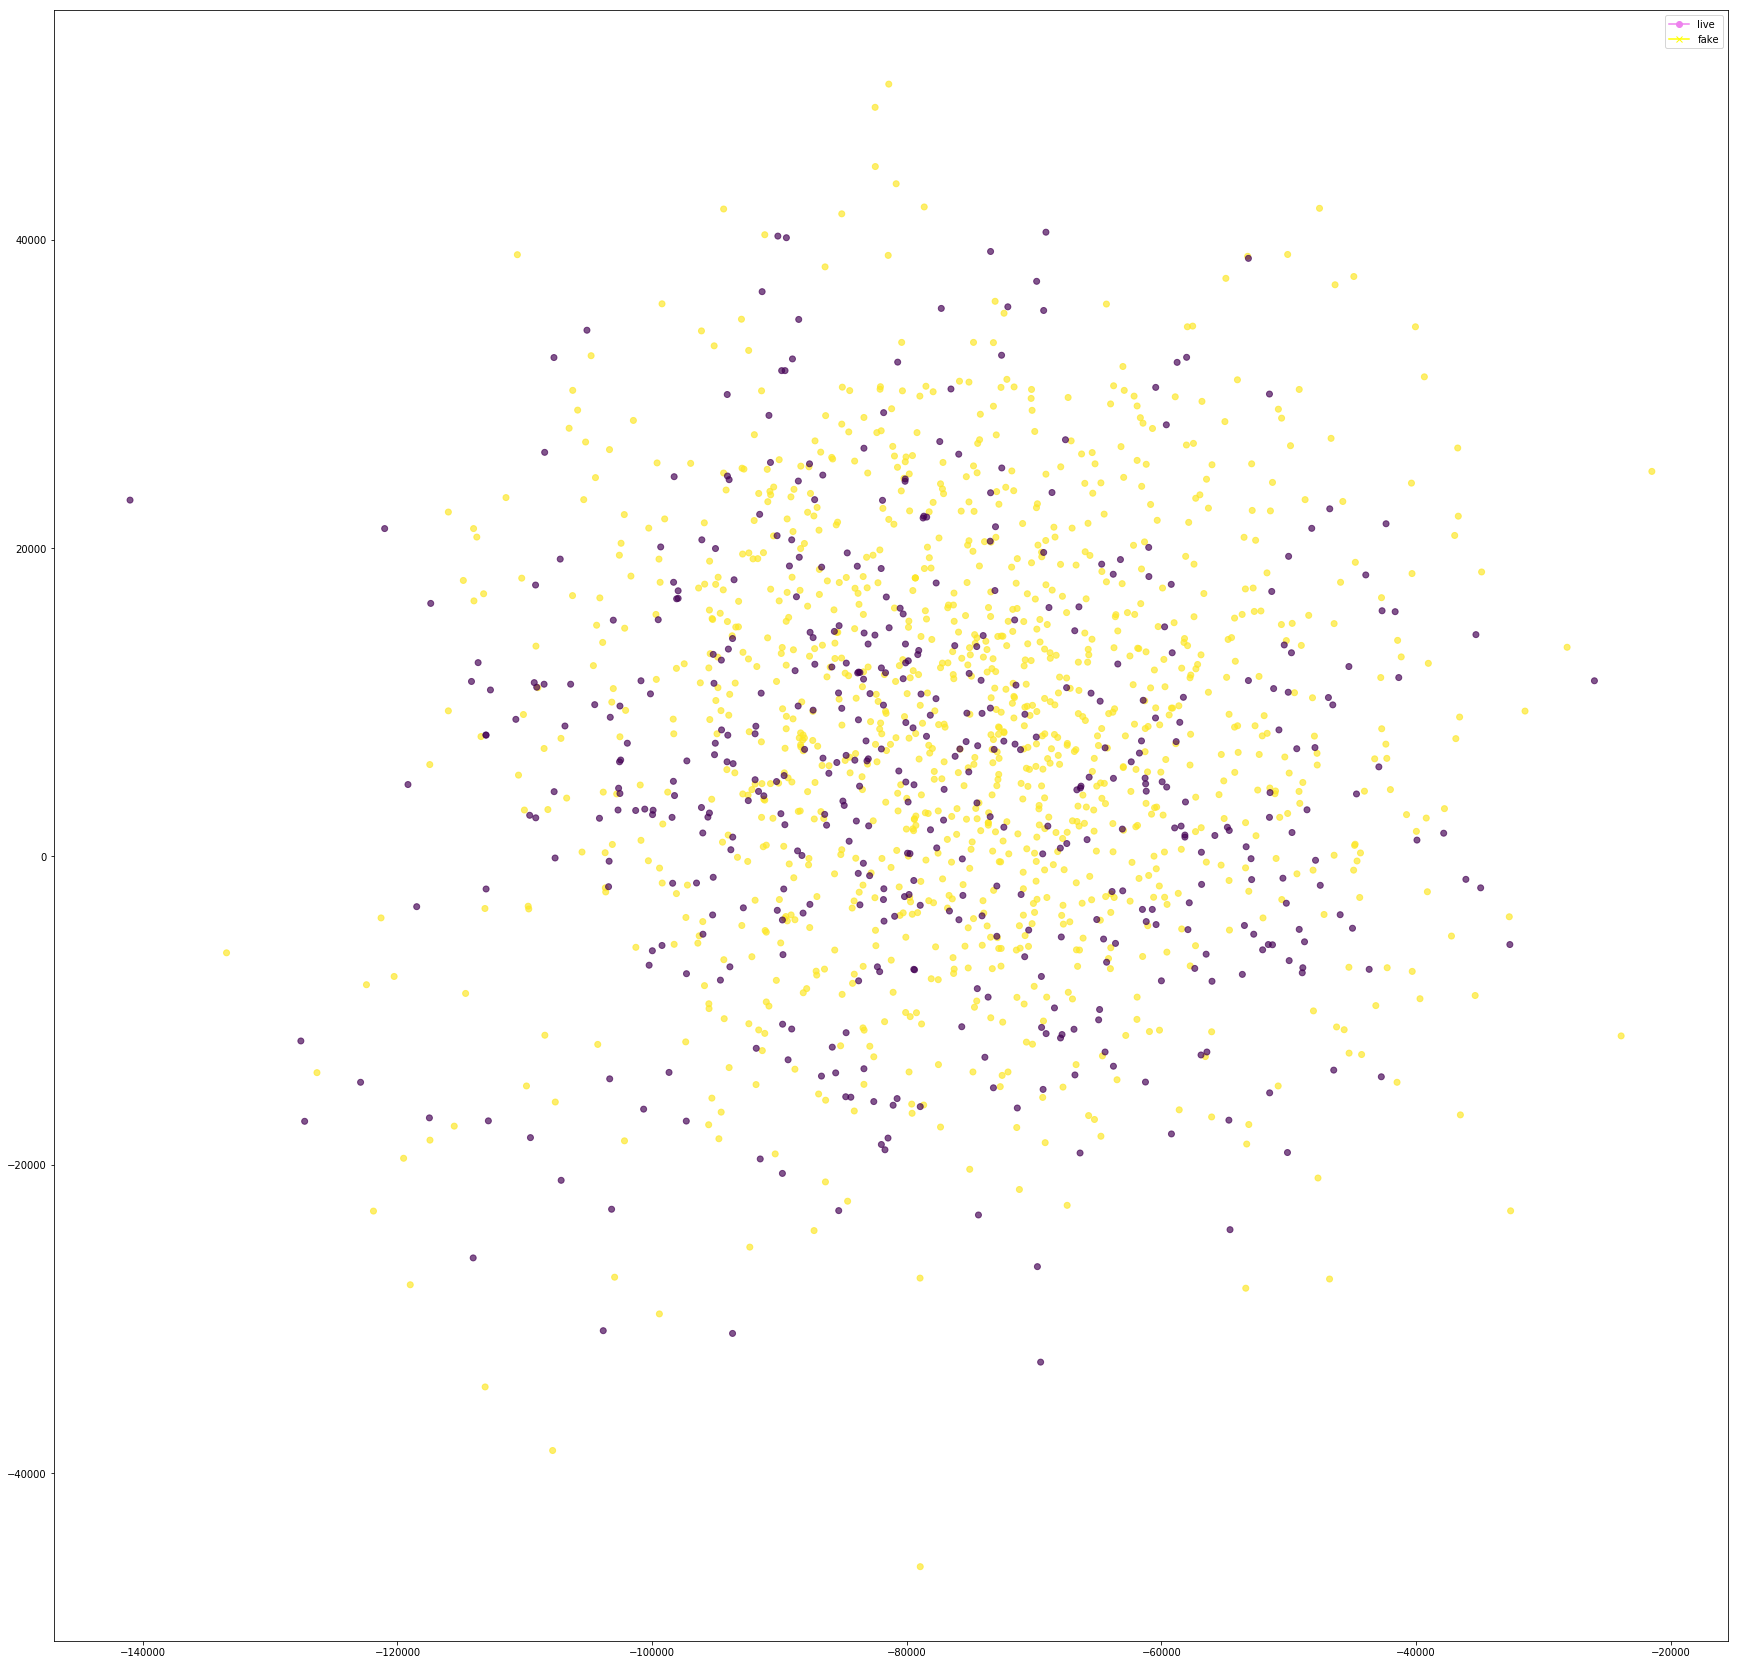

CPU times: user 2.42 s, sys: 1.12 s, total: 3.54 s
Wall time: 2.87 s


In [41]:
%%time
projection = random_projection.SparseRandomProjection(n_components = 2)
data_2d_rp = projection.fit_transform(X)

pylab.figure(figsize = (30, 30))
pylab.scatter(data_2d_rp[:, 0], data_2d_rp[:, 1], c = Y, alpha = 0.67)

pylab.legend((live,fake),('live','fake'),numpoints=1, loc=1)

plt.savefig('Random_Projection.png')

pylab.show()

# PCA

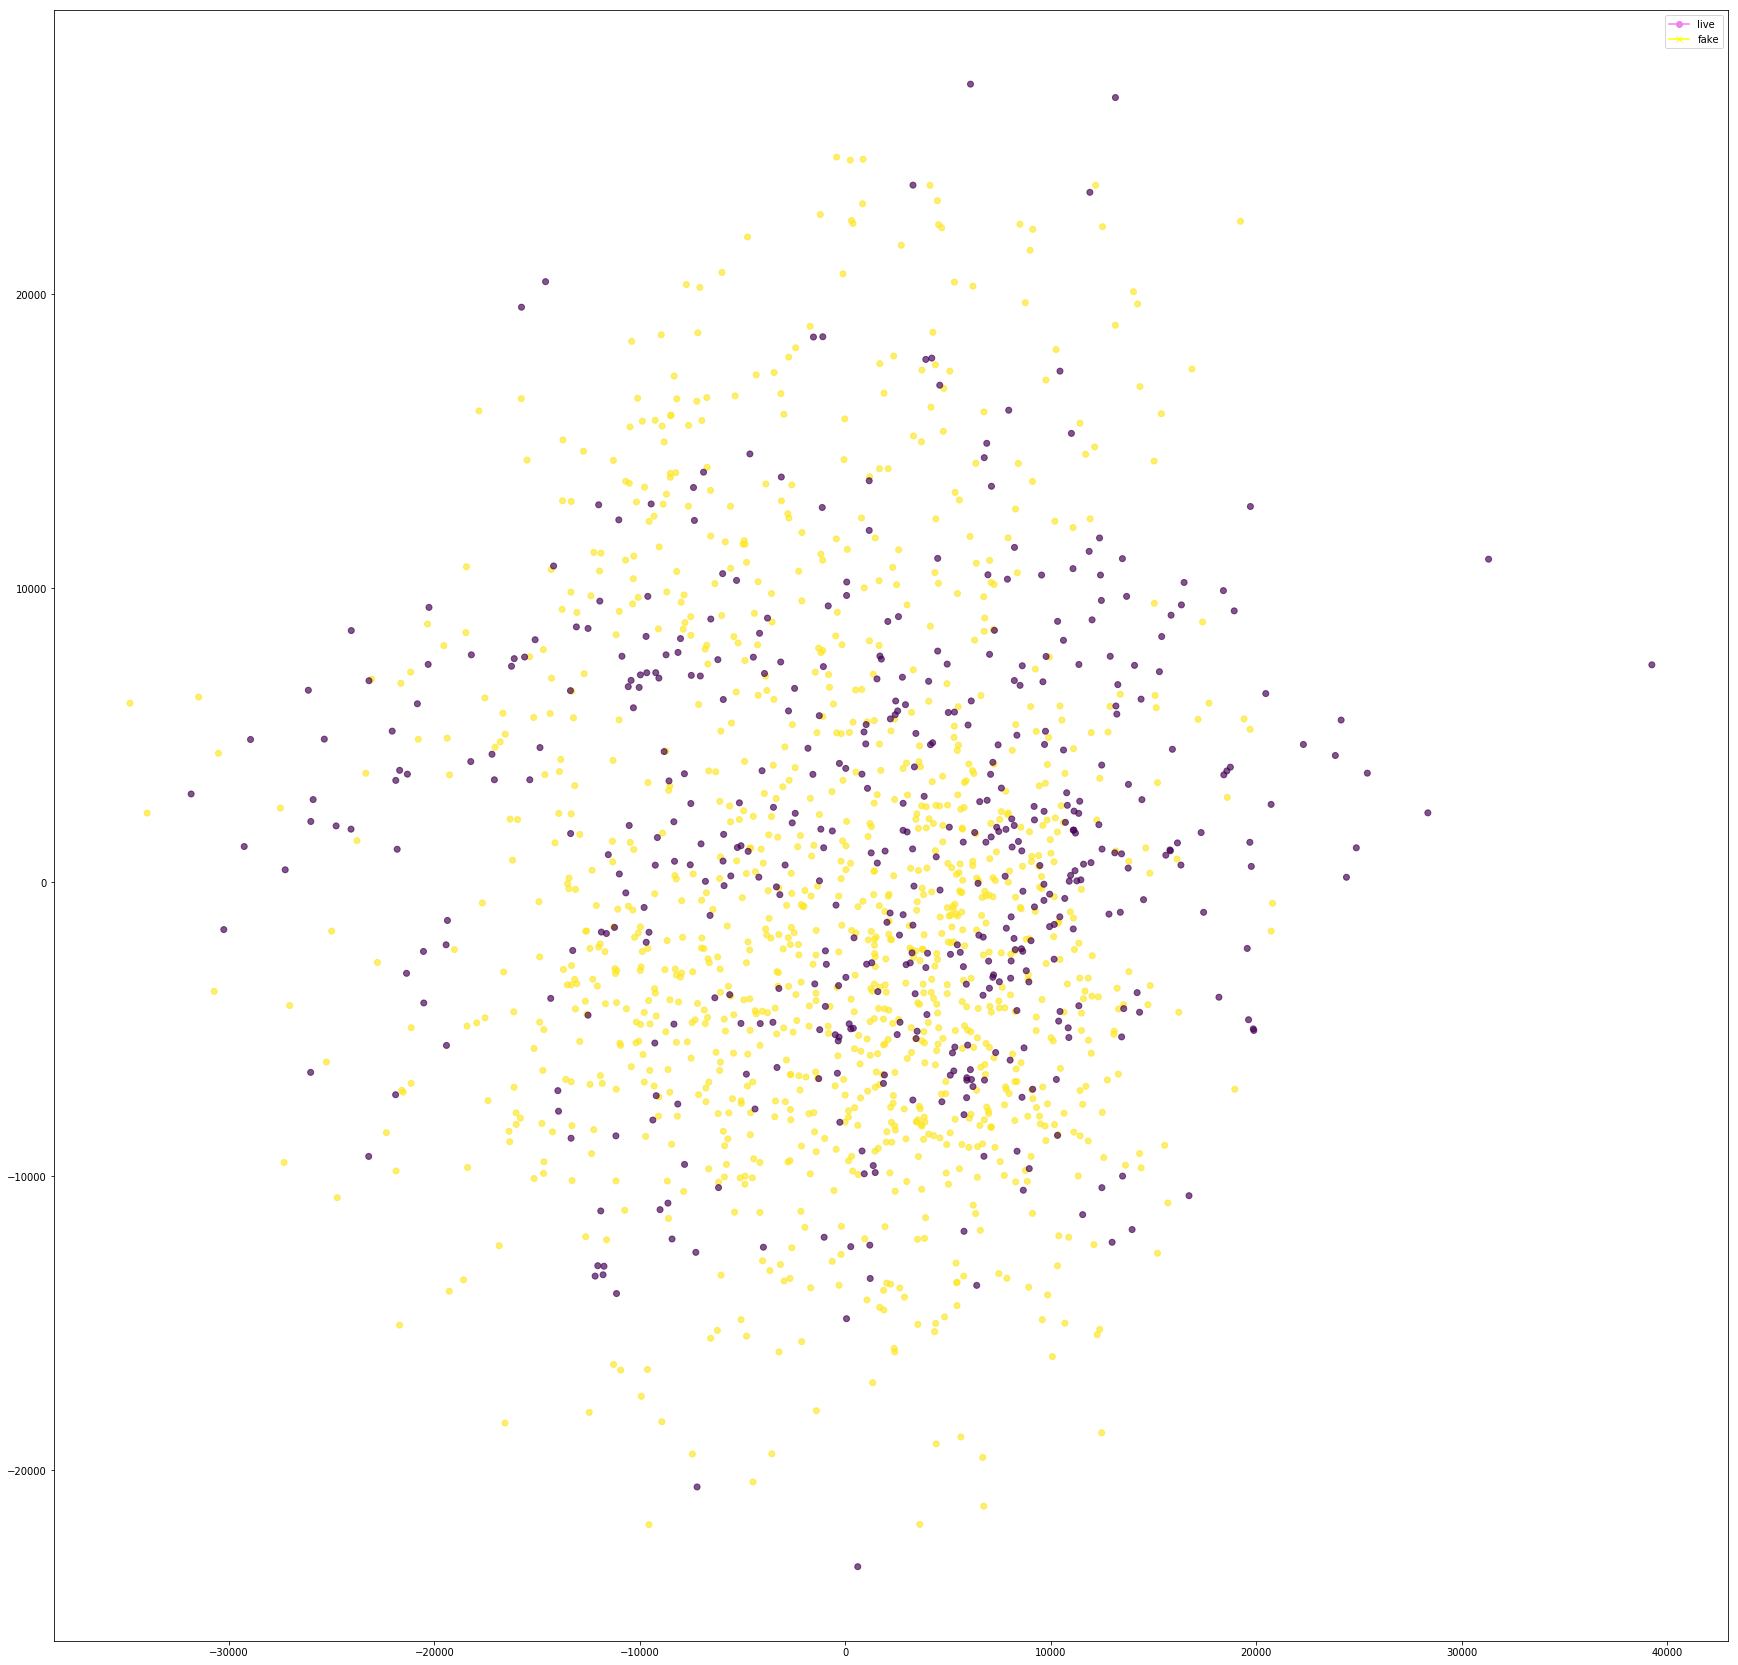

CPU times: user 23.4 s, sys: 4.9 s, total: 28.3 s
Wall time: 8.11 s


In [40]:
%%time
pca = PCA(n_components = 2)
data_2d_pca = pca.fit_transform(X)

pylab.figure(figsize = (30, 30))
pylab.scatter(data_2d_pca[:, 0], data_2d_pca[:, 1], c = Y, alpha = 0.67)

pylab.legend((live,fake),('live','fake'),numpoints=1, loc=1)

plt.savefig('PCA.png')

pylab.show()

# Multidimensional Scaling - MDS

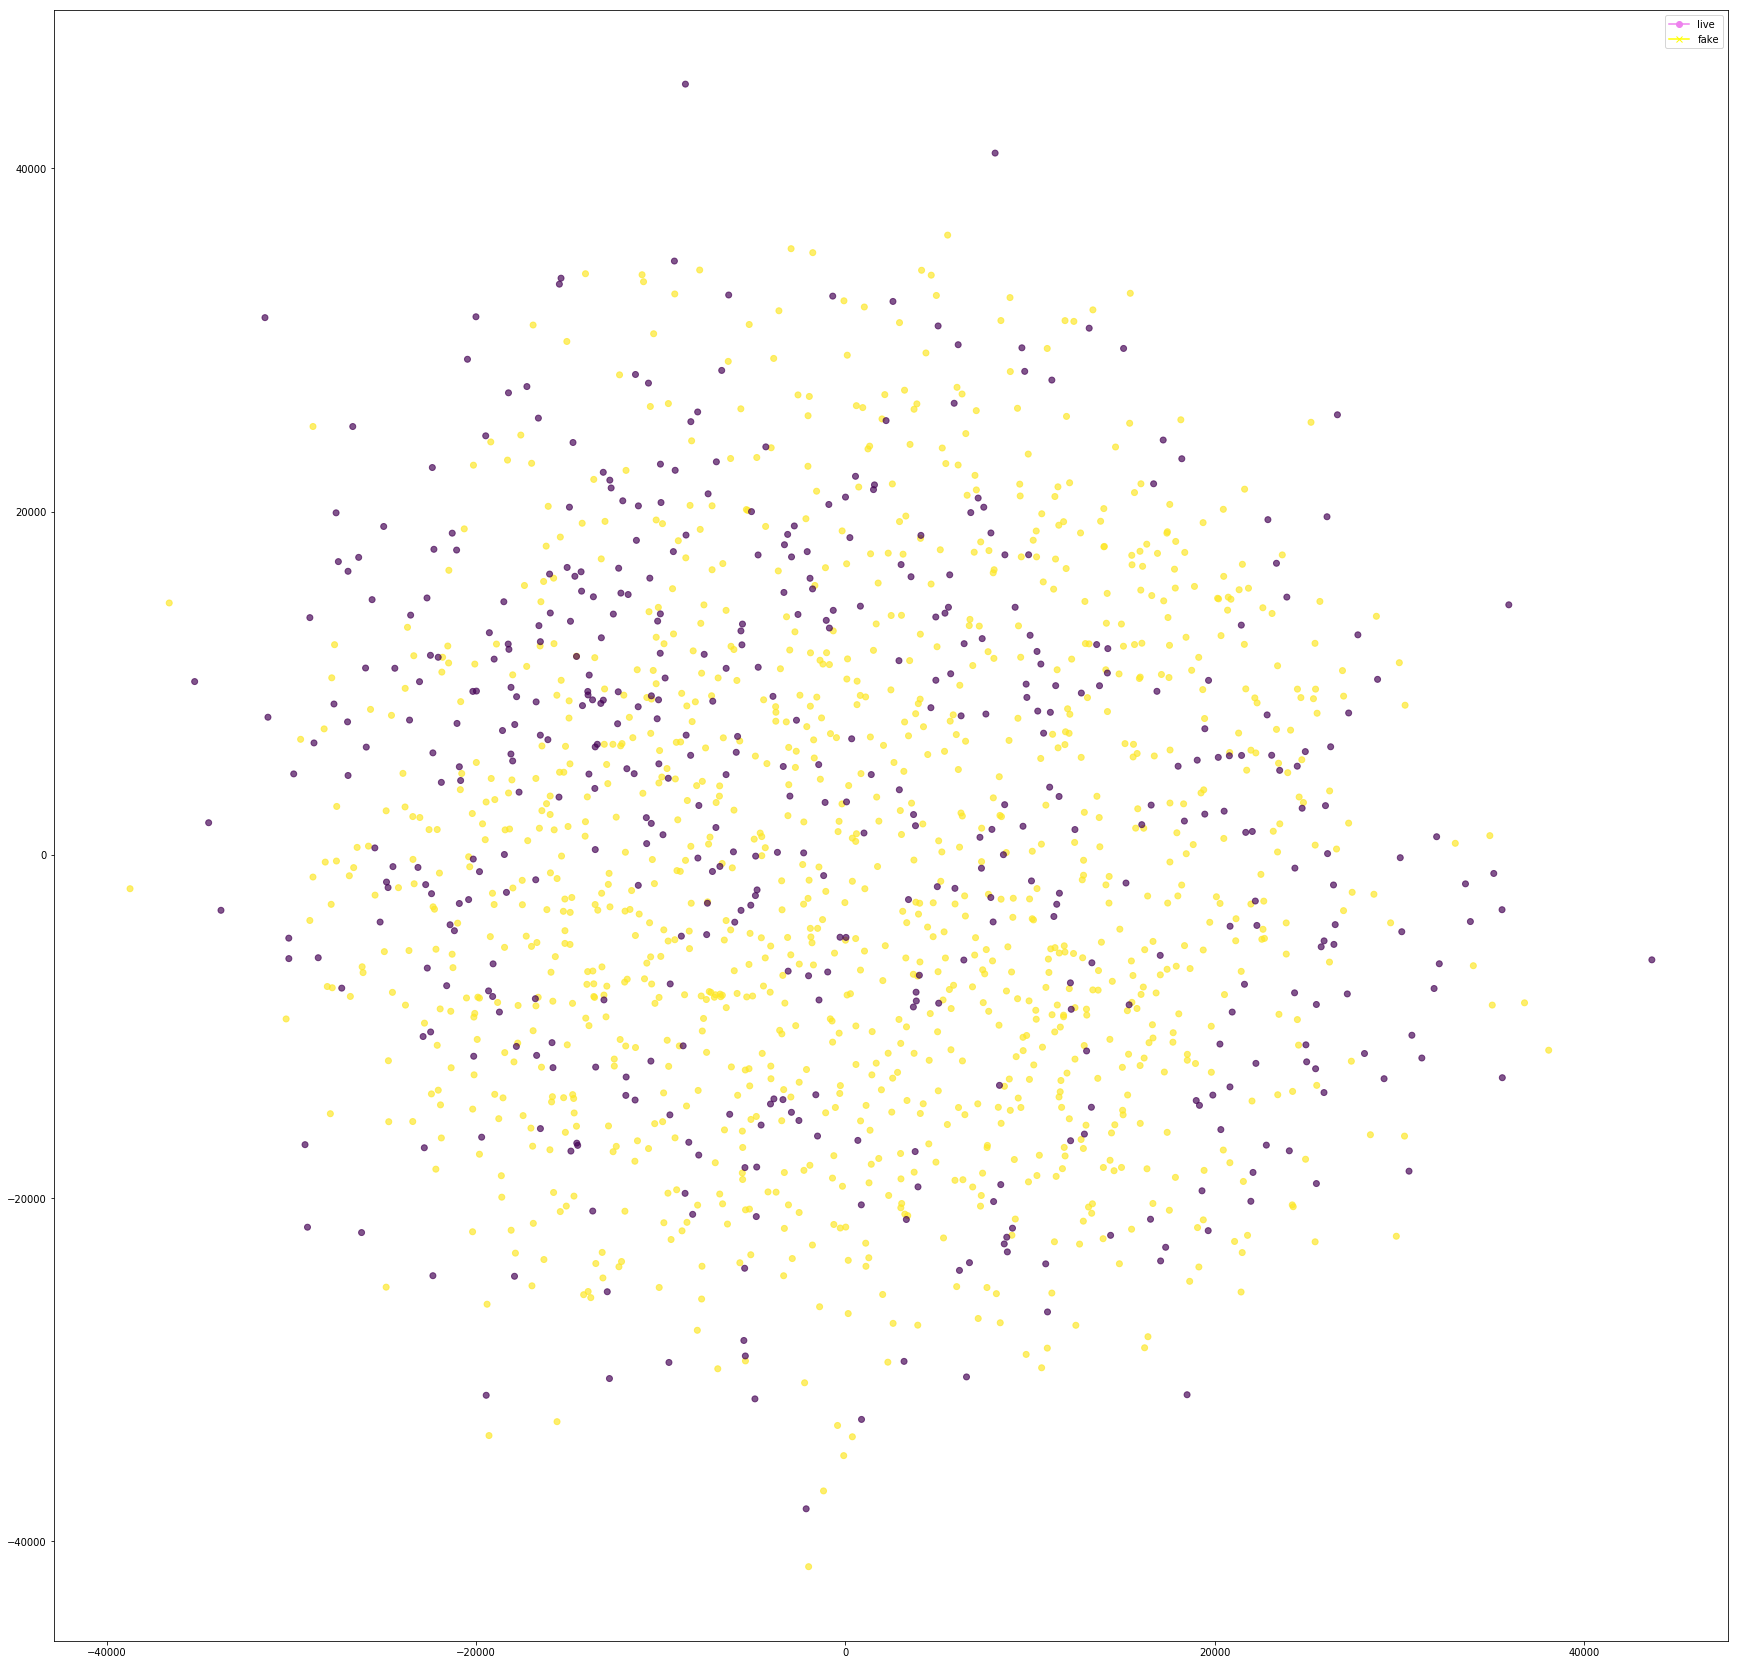

CPU times: user 31.6 s, sys: 15.6 s, total: 47.1 s
Wall time: 11.5 s


In [44]:
%%time
mds = MDS(n_components = 2, n_init = 1, max_iter = 100, random_state = 0)
data_2d_mds = mds.fit_transform(X)

pylab.figure(figsize = (30, 30))
pylab.scatter(data_2d_mds[:, 0], data_2d_mds[:, 1], c = Y, alpha = 0.67)

pylab.legend((live,fake),('live','fake'),numpoints=1, loc=1)

plt.savefig('MDS.png')

pylab.show()

# TSNE

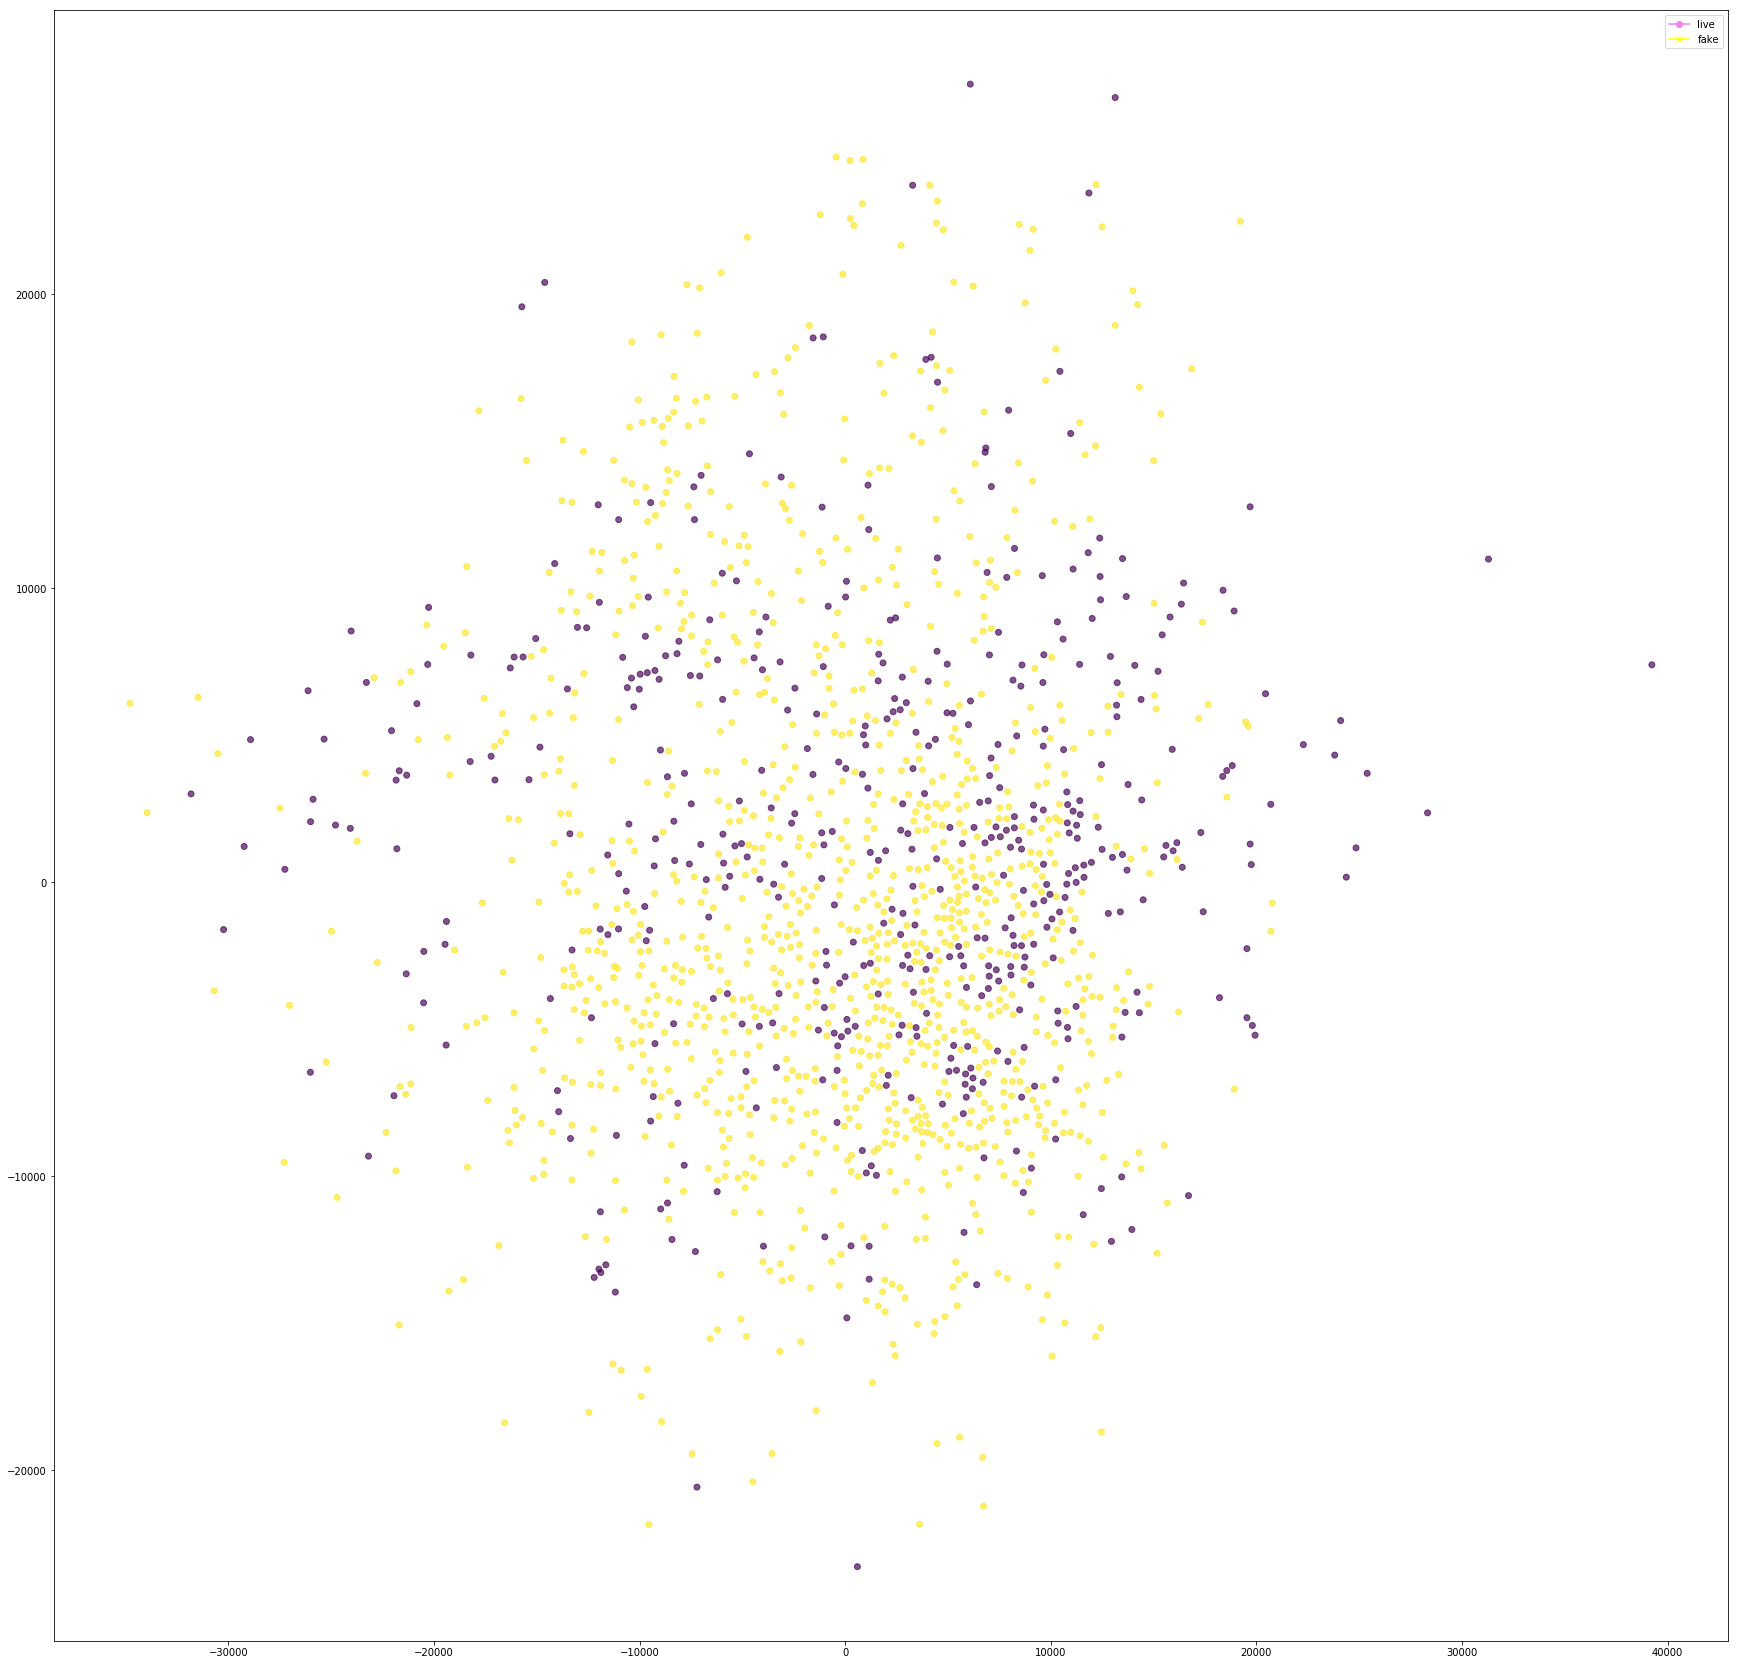

CPU times: user 13min 42s, sys: 4.15 s, total: 13min 46s
Wall time: 13min 40s


In [45]:
%%time
tsne = TSNE(n_components = 2, init = 'pca')
data_2d_tsne = tsne.fit_transform(X)

pylab.figure(figsize = (30, 30))
pylab.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c = Y, alpha = 0.67)

pylab.legend((live,fake),('live','fake'),numpoints=1, loc=1)

plt.savefig('t-SNE.png')

pylab.show()